In [487]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [488]:
matches_df = pd.read_csv('../data/matches_clean_20250720_223207.csv')

In [489]:
#import the player data 
scorers_df = pd.read_csv('../data/players_cleaned_20250722_204616.csv')
# converst scorer_df team_id to str
scorers_df['team_id']= scorers_df['team_id'].astype('str')
scorers_df['team_id']= scorers_df['team_id'].str.replace('.0','', regex=False)

In [490]:
#import the team data
team_stats = pd.read_csv('../data/team_stats(raw)_20250723_013940.csv')
#convert team id to str
team_stats['team_id']= team_stats['team_id'].astype(str)

In [491]:
#merge teamdata and scorers data together on team id to get the total goals scored by the teams
team_player_stats = pd.merge(scorers_df,team_stats[['team_id','goalsFor']], on='team_id')

In [492]:
# Rename the goals for column to total team goals
team_player_stats = team_player_stats.rename(columns={
    'goalsFor':'total_team_goals', 
})


# Feature Engineering

In [493]:
matches_df['goal_difference'] = matches_df['home_goals'] - matches_df['away_goals']
matches_df['total_goals'] = matches_df['home_goals'] + matches_df['away_goals']
matches_df['is_draw'] = matches_df['result'] == 'D'
matches_df['home_win'] = matches_df['result'] == 'H'
matches_df['away_win'] = matches_df['result'] == 'A'
# Create a scoreline column
matches_df['scoreline'] = matches_df['home_goals'].astype(str) + " - " + matches_df['away_goals'].astype(str)


In [494]:
team_player_stats['goals_per_match'] = (team_player_stats['goals'] / team_player_stats['appearances']).round(2)
team_player_stats['non_penalty_goals'] = (team_player_stats['goals'] - team_player_stats['penalty_goals'])
team_player_stats['goal_contribution'] = (team_player_stats['goals'] + team_player_stats['assists'])
team_player_stats['minutes_per_goal'] =np.where(team_player_stats['goals'] > 0, team_player_stats['minutes'] / team_player_stats['goals'],0  ).round(2)
team_player_stats['goal_contribution_ratio'] = (team_player_stats['goals'] / team_player_stats['total_team_goals'])


In [495]:
team_stats['win_ratio'] = (team_stats['wins'] / team_stats['games_played']).round(2)
team_stats['loss_ratio'] = (team_stats['losses'] / team_stats['games_played']).round(2)
team_stats['points_per_game'] = (team_stats['points'] / team_stats['games_played']).round(2)
team_stats['avg_goals_scored'] = (team_stats['goalsFor'] / team_stats['games_played']).round(2)
team_stats['avg_goals_conceded'] = (team_stats['goals_against'] / team_stats['games_played']).round(2)

# Exploratory Data Analysis: 2023/24 Premier League Season

This notebook analyzes match-level data from the 2023/2024 Premier League season. The goal is to identify patterns in team performance, goal scoring, home/away advantage, and matchday dynamics. This supports recruitment, performance evaluation, and tactical insights.


- Which team had the most home wins?

In [496]:
home_wins = matches_df[matches_df['result'] == 'H']
home_win_counts = home_wins['home_team'].value_counts()
top_home_team = home_win_counts.idxmax()
top_home_wins = home_win_counts.max()
print(f'Team with the most home wins : {top_home_team} ({top_home_wins})')

Team with the most home wins : Arsenal FC (15)


- Which team scored the most goals overall?

In [497]:
home_goals_df = matches_df.groupby('home_team')['home_goals'].sum()
away_goals_df = matches_df.groupby('away_team')['away_goals'].sum()
total_goals = home_goals_df.add(away_goals_df, fill_value=0)
top_scorer_team = total_goals.idxmax()
top_scorer_goals = total_goals.max()
print(f" Team with most total goals: {top_scorer_team} ({int(top_scorer_goals)} goals)")

 Team with most total goals: Manchester City FC (96 goals)


- What was the average number of goals per match?

In [498]:
average_goals_per_match = (matches_df['total_goals'].sum() / 380).round(2)
print(f'Average goals scored per match : {average_goals_per_match}')

Average goals scored per match : 3.28


- Was there a home team advantage?

In [499]:
home_wins = matches_df[matches_df['result'] == 'H']
home_win_count = home_wins['home_win'].count()
away_wins =  matches_df[matches_df['result'] == 'A']
away_win_count = away_wins['away_win'].count()
print(f'Home wins: {home_win_count}')
print(f'Away wins: {away_win_count}')
print(f'Home teams win {home_win_count - away_win_count} more matches than away teams throughout the season')
print('There is an home advantage')

Home wins: 175
Away wins: 123
Home teams win 52 more matches than away teams throughout the season
There is an home advantage


- How often did matches end in a draw?

In [500]:
drawn_match = matches_df[matches_df['is_draw'] == True]
drawn_match_count = drawn_match['is_draw'].count()
drawn_match_count
print(f'There are {drawn_match_count} drawn matches')

There are 82 drawn matches


- What’s the most common scoreline?

In [501]:

#  Count each scoreline
scoreline_counts = matches_df['scoreline'].value_counts()

# Step 3: Get the most common
most_common_scoreline = scoreline_counts.idxmax()
most_common_count = scoreline_counts.max()

print(f" Most common scoreline: {most_common_scoreline} ({most_common_count} times)")

 Most common scoreline: 1 - 1 (38 times)


- Is there a pattern in total goals across matchdays?

In [502]:
goals_by_matchday = matches_df.groupby('matchday')['total_goals'].sum().sort_index()

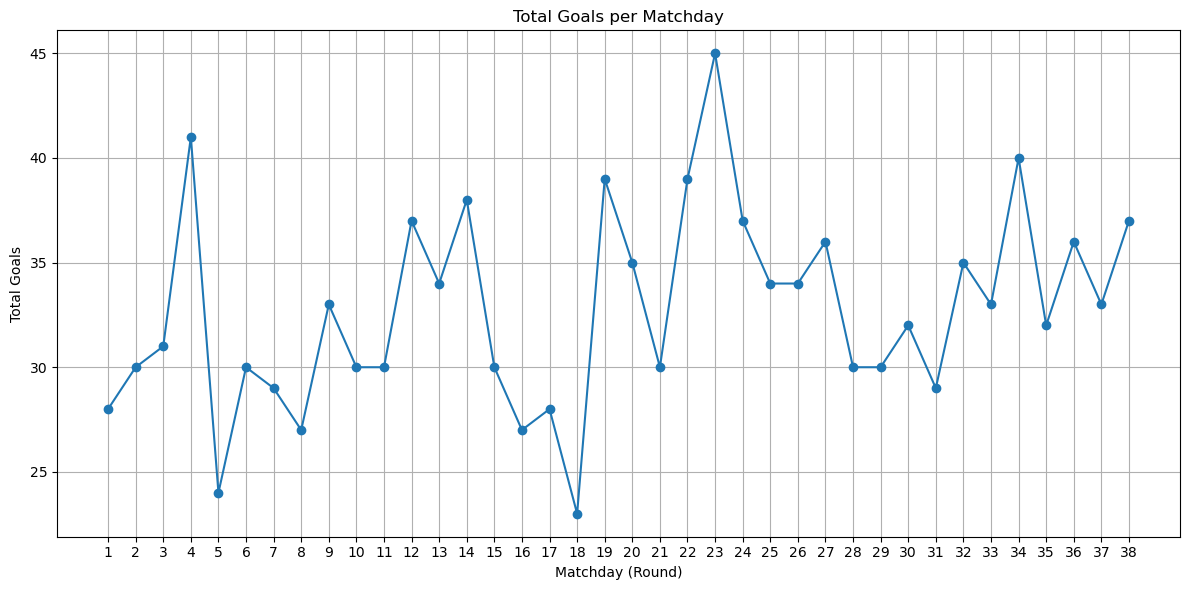

In [503]:
plt.figure(figsize=(12, 6))
plt.plot(goals_by_matchday.index, goals_by_matchday.values, marker='o', linestyle='-')
plt.title("Total Goals per Matchday")
plt.xlabel("Matchday (Round)")
plt.ylabel("Total Goals")
plt.grid(True)
plt.xticks(range(1, 39))  # Matchdays 1 to 38
plt.tight_layout()
plt.show()

In [504]:
matchday_23 = matches_df[matches_df['matchday'] == 23]
matchday_23 = matchday_23[['home_team','away_team', 'total_goals','scoreline']]
matchday_23


,home_team,away_team,total_goals,scoreline
220,Everton FC,Tottenham Hotspur FC,4,2 - 2
221,Brighton & Hove Albion FC,Crystal Palace FC,5,4 - 1
222,Burnley FC,Fulham FC,4,2 - 2
223,Newcastle United FC,Luton Town FC,8,4 - 4
224,Sheffield United FC,Aston Villa FC,5,0 - 5
225,AFC Bournemouth,Nottingham Forest FC,2,1 - 1
226,Chelsea FC,Wolverhampton Wanderers FC,6,2 - 4
227,Manchester United FC,West Ham United FC,3,3 - 0
228,Arsenal FC,Liverpool FC,4,3 - 1
229,Brentford FC,Manchester City FC,4,1 - 3


In [505]:
print(f'The matchday with the most goals: Matchday 23 ({matchday_23['total_goals'].sum()})')

The matchday with the most goals: Matchday 23 (45)


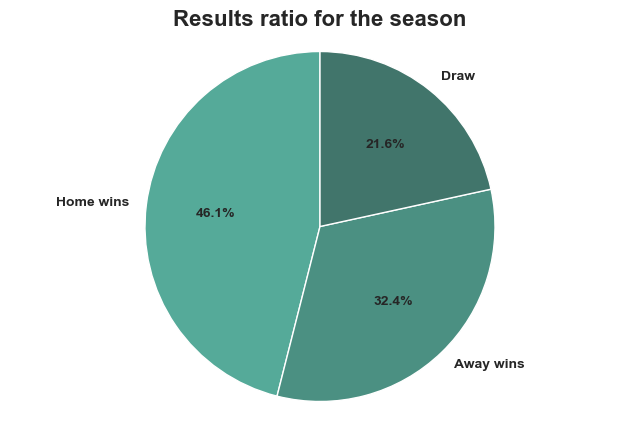

In [506]:
result = matches_df['result'].value_counts()

sns.set_style("whitegrid")
sns.set_palette('dark:#5A9_r')


plt.figure(figsize=(8, 5))
colors = plt.cm.Set3(np.linspace(0, 1, len(result)))

wedges, texts, autotexts = plt.pie(
    result,
    labels=['Home wins', 'Away wins','Draw'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
plt.title('Results ratio for the season', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

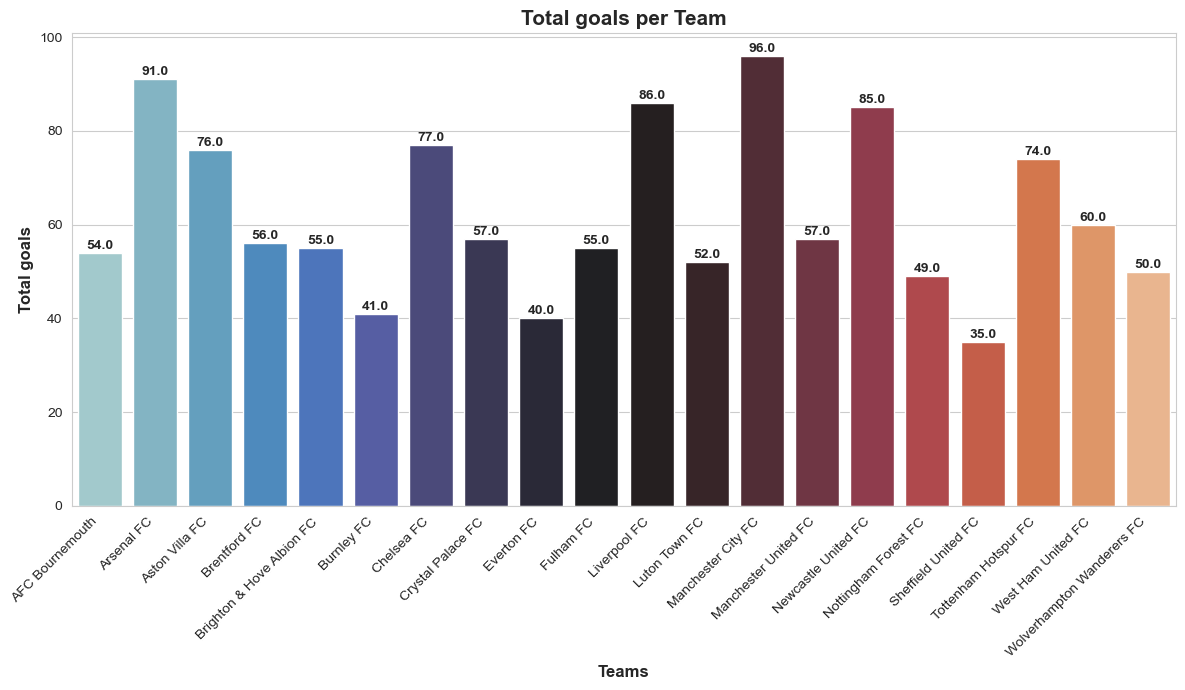

In [507]:
sns.set_style("whitegrid")

# Create the barplot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    x= total_goals.index,
    y= total_goals.values,
    hue= total_goals.index,
    palette="icefire",
    legend=False    
)

# Add value labels on top of each bar
for i, v in enumerate(total_goals.values):
    barplot.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Teams', fontsize=12, fontweight='bold')
plt.ylabel('Total goals', fontsize=12, fontweight='bold')
plt.title('Total goals per Team', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Top 10 Scorelines'}, xlabel='scoreline'>

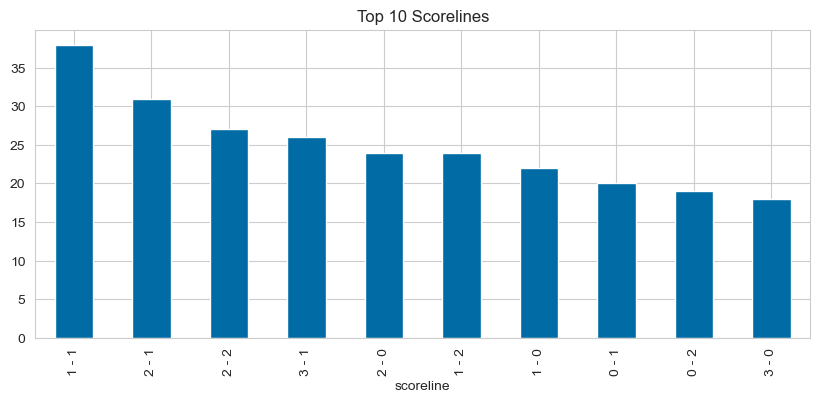

In [508]:
plt.style.use('tableau-colorblind10')
matches_df['scoreline'].value_counts().head(10).plot(kind='bar', figsize=(10, 4), title='Top 10 Scorelines')

Text(0.5, 1.0, 'Distribution of Total Goals per Match')

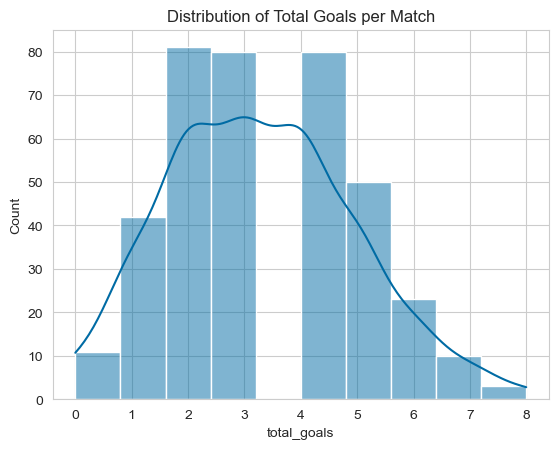

In [509]:
sns.histplot(matches_df['total_goals'],bins=10 , kde=True)
plt.title('Distribution of Total Goals per Match')

In [ ]:
goals_conceded = matches_df.groupby('home_team')['away_goals'].sum() + matches_df.groupby('away_team')['home_goals'].sum()
most_gc = goals_conceded.sort_values(ascending=False).head(10)


# Create the barplot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    x= most_gc.index,
    y= most_gc.values,
    hue= most_gc.index,
    palette="icefire",
    legend=False    
)

# Add value labels on top of each bar
for i, v in enumerate(most_gc.values):
    barplot.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Teams', fontsize=12, fontweight='bold')
plt.ylabel('Goals Conceded', fontsize=12, fontweight='bold')
plt.title('Total goals conceded per Team', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

- Who are the top 10 most efficient scorers (by minutes per goal)

In [ ]:
# goals greater than
_100plusmintes = team_player_stats[team_player_stats['minutes'] > 100]
_100plusmintes[['name','minutes','minutes_per_goal']].sort_values(by='minutes_per_goal', ignore_index=True).head(10)

- How do goal contributions vary by position group

In [ ]:
goal_contribution_per_position = team_player_stats.groupby('position')['goal_contribution'].sum()
goal_contribution_per_position.reset_index(). sort_values(by='goal_contribution', ascending=False)

In [ ]:
team_player_stats.corr(numeric_only=True)

- Which players overperformed based on limited appearances?

In [ ]:
# Create goals per game metric
team_player_stats['goals_per_game'] = team_player_stats['goals'] / team_player_stats['appearances']

# Filter players with <= 10 appearances but high scoring rate
overperformers = team_player_stats[(team_player_stats['appearances'] <= 20) & (team_player_stats['goals_per_game'] >= 0.4)]

# Sort by goals_per_game
overperformers = overperformers.sort_values(by='goals_per_game', ascending=False).reset_index()

print(overperformers[['name', 'team', 'appearances', 'goals', 'goals_per_game']])
print('')
print(f'The Most Effiecient Goalscorer is {overperformers.iloc[0,1]} with {overperformers.iloc[0,6]} appearances and {overperformers.iloc[0,9]} goals.')

- Is there a clear gap between top 5 scorers and the rest?

In [ ]:
# Top 5 scorers
top_5 = scorers_df.sort_values(by='goals', ascending=False).head(5)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(scorers_df['goals'], bins=20, kde=True)
plt.axvline(top_5['goals'].min(), color='red', linestyle='--', label='Top 5 lower bound')
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals')
plt.legend()
plt.show()



- Percentage of goals scored by top 20 scorers in the league

In [ ]:
total_goals = team_stats['goalsFor'].sum()
top_20_scorers = scorers_df.sort_values(by='goals', ascending =False).head(20)
sum_goals_of_top_20_scorers = top_20_scorers['goals'].sum()
print(f'The top 20 scorers in the league scored {((sum_goals_of_top_20_scorers/total_goals)* 100).round(1)} % of the total league goals')

- Do top scorers tend to play more minutes or are they super-subs?

In [ ]:
# Scatter plot: Minutes played vs goals scored
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scorers_df, x='minutes', y='goals', hue='position', alpha=0.7)
plt.title('Do Top Scorers Play More Minutes or Are They Super-Subs?')
plt.xlabel('Minutes Played')
plt.ylabel('Goals Scored')
plt.show()

# Optional: Correlation
correlation = scorers_df['minutes'].corr(scorers_df['goals'])
print(f"Correlation between minutes played and goals scored: {correlation:.2f}")


- Which team had the best points-per-game performance?

In [ ]:
most_points_per_game = team_stats[['team_name','points','points_per_game', 'games_played' ]].sort_values(by='points_per_game', ascending=False)
print(f'{most_points_per_game.iloc[0,0]} ({most_points_per_game.iloc[0,2]}) has the most points per game.')

- How does goal difference relate to final points total?

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(data=team_stats, x='goal_difference', y='points')
plt.title('Goal Difference vs Final Points')
plt.xlabel('Goal Difference')
plt.ylabel('Points')
plt.show()

# Correlation between goal difference and points
correlation = team_stats['goal_difference'].corr(team_stats['points'])
print(f"Correlation between goal difference and points: {correlation:.2f}")

In [ ]:
team_stats

- Which team had the best defense? (lowest avg goals conceded)

In [ ]:
best_defense = team_stats.sort_values(by='avg_goals_conceded').head(5).reset_index()

print(best_defense[['team_name', 'goals_against', 'games_played', 'avg_goals_conceded']])

- How does win ratio compare between top 5 and bottom 5 teams?

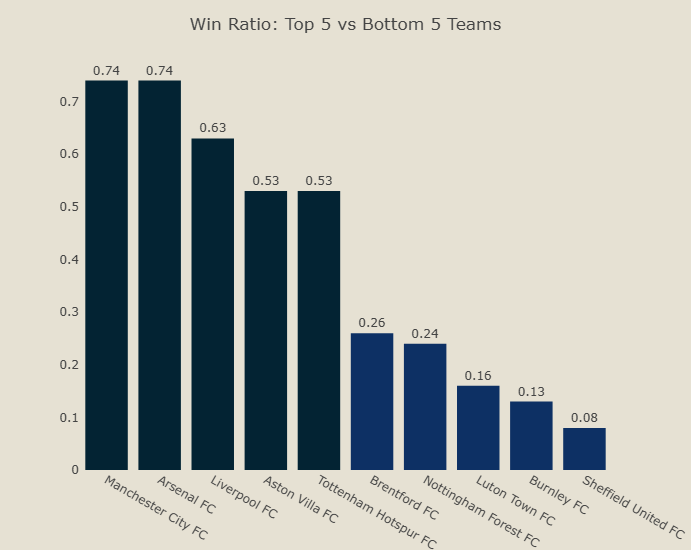

In [510]:


teams_sorted = team_stats.sort_values(by='points', ascending=False)

# Top and bottom 5
top_5 = teams_sorted.head(5)
bottom_5 = teams_sorted.tail(5)

# Combine for comparison
compare_df = pd.concat([top_5, bottom_5])
compare_df['Tier'] = ['Top 5'] * 5 + ['Bottom 5'] * 5

# Bar plot
fig = px.bar(
    compare_df,
    x='team_name',
    y='win_ratio',
    color='Tier',
    text='win_ratio',
    width= 1100,
    height= 550,
    color_discrete_sequence=px.colors.sequential.thermal
    )

fig.update_traces(textposition='outside')
fig.update_layout(
    title={'text':'Win Ratio: Top 5 vs Bottom 5 Teams', 'x':0.5, 'xanchor': 'center'},
    xaxis=dict(title='', showgrid=False, zeroline=False),
    yaxis=dict(title='', showgrid=False, zeroline=False),
    plot_bgcolor='#E6E1D3',
    showlegend=False,
    paper_bgcolor='#E6E1D3',
)
fig.show()

- Is there a relationship between goal scoring and league standing?

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Sort for labeling top teams
top_teams = team_stats.sort_values(by='points', ascending=False).head(5)

fig = px.scatter(
    team_stats,
    x='goalsFor',
    y='points',

    color='points',
    color_continuous_scale=px.colors.sequential.Plasma,
    size='wins',  # Optional: size points by number of wins
    width=1100,
    height=600
)

fig.update_traces(
    marker=dict(opacity=0.85, line=dict(width=1, color='DarkSlateGrey')),
    textposition='top center'
)

fig.update_layout(
    title={
        'text': ' Goals Scored vs League Points – Is Attack the Best Strategy?',
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=22, family='Helvetica', color='#222')
    },
    xaxis=dict(
        title='Goals Scored',
        showgrid=True,
        zeroline=False,
        ticks='outside',
        tickfont=dict(size=14)
    ),
    yaxis=dict(
        title='League Points',
        showgrid=True,
        zeroline=False,
        ticks='outside',
        tickfont=dict(size=14)
    ),
    coloraxis_colorbar=dict(
        title='Points',
        ticks='outside'
    ),
    plot_bgcolor='#E6E1D3',
    paper_bgcolor='#E6E1D3',
    font=dict(family='Arial', size=12, color='#333'),
    hoverlabel=dict(bgcolor='white', font_size=13, font_family='Arial'),
    showlegend=False
)



fig.show()


- Compare offensive vs defensive teams visually (scatter plot)

In [ ]:
avg_scored = team_stats['avg_goals_scored'].mean()
avg_conceded = team_stats['avg_goals_conceded'].mean()

fig = sns.scatterplot(
    team_stats,
    x='avg_goals_scored',
    y='avg_goals_conceded',
)
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Calculate league averages
avg_scored = team_stats['avg_goals_scored'].mean()
avg_conceded = team_stats['avg_goals_conceded'].mean()

fig = px.scatter(
    team_stats,
    x='avg_goals_scored',
    y='avg_goals_conceded',
    color_continuous_scale=px.colors.sequential.Greys,
    width=1100,
    height=600,
    color='points'
)

# Add league average lines
fig.add_shape(
    type='line',
    x0=avg_scored, x1=avg_scored,
    y0=team_stats['avg_goals_conceded'].min(), y1=team_stats['avg_goals_conceded'].max(),
    line=dict(dash='dash', color='blue'),
    name='Avg Goals Scored'
)

fig.add_shape(
    type='line',
    x0=team_stats['avg_goals_scored'].min(), x1=team_stats['avg_goals_scored'].max(),
    y0=avg_conceded, y1=avg_conceded,
    line=dict(dash='dash', color='red'),
    name='Avg Goals Conceded'
)

# Customize layout and title
fig.update_traces(
    marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
    textposition='top center'
)

fig.update_layout(
    title={
        'text': ' Offensive vs Defensive Balance – Where Does Each Team Stand?',
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=22)
    },
    xaxis=dict(
        title='Avg Goals Scored per Match',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Avg Goals Conceded per Match',
        showgrid=True,
        zeroline=False
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=13),
    showlegend=False
)

# Annotate quadrants for interpretation
fig.add_annotation(
    x=avg_scored + 0.15,
    y=avg_conceded + 0.15,
    text="Leaky but Attacking",
    showarrow=False,
    font=dict(color='gray')
)
fig.add_annotation(
    x=avg_scored + 0.15,
    y=avg_conceded - 0.15,
    text="Strong Offense & Defense",
    showarrow=False,
    font=dict(color='darkgreen')
)
fig.add_annotation(
    x=avg_scored - 0.3,
    y=avg_conceded + 0.15,
    text=" Weak Defense & Attack",
    showarrow=False,
    font=dict(color='gray')
)
fig.add_annotation(
    x=avg_scored - 0.3,
    y=avg_conceded - 0.15,
    text="Solid Defense, Low Scoring",
    showarrow=False,
    font=dict(color='darkblue')
)

fig.show()


## 📈 Summary of Insights

- Most matches ended in a 1 - 1 scoreline.
- Manchester City had the highest total goals, while Sheffield United FC conceded the most.
- Home teams won approximately 46% of matches, showing a clear home-field advantage.
- Matchday 22 had a spike in goals, possibly due to derby or holiday fixtures.
- The Most Effiecient Goalscorer is M. Olise with 19 appearances and 10 goals.
- Manchester City FC (2.39) has the most points per game.
- Arsenal has the best defense in the league, Manchester City FC has the best offense.
- There is a strong correlation (0.97) between goal difference and points.

In [459]:
matches_df.head()

,match_id,date,match_status,matchday,stage,home_team,away_team,home_goals,away_goals,result,goal_difference,total_goals,is_draw,home_win,away_win,scoreline
0,435943,2023-08-11 19:00:00+00:00,FINISHED,1,REGULAR_SEASON,Burnley FC,Manchester City FC,0,3,A,-3,3,False,False,True,0 - 3
1,435944,2023-08-12 12:00:00+00:00,FINISHED,1,REGULAR_SEASON,Arsenal FC,Nottingham Forest FC,2,1,H,1,3,False,True,False,2 - 1
2,435945,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,AFC Bournemouth,West Ham United FC,1,1,D,0,2,True,False,False,1 - 1
3,435946,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,Brighton & Hove Albion FC,Luton Town FC,4,1,H,3,5,False,True,False,4 - 1
4,435947,2023-08-12 14:00:00+00:00,FINISHED,1,REGULAR_SEASON,Everton FC,Fulham FC,0,1,A,-1,1,False,False,True,0 - 1


In [460]:
matches_df.drop(columns = ['match_status','stage','match_id'], inplace=True)

In [480]:
matches_df.to_csv('../data/matches_clean.csv',index=None)
team_stats.to_csv('../data/team_stats.csv', index=None)

In [462]:
scorers = team_player_stats.sort_values(by='goals', ascending=False).reset_index()


In [ ]:
scorers = scorers.drop('index', axis=1)


In [470]:
scorers.to_csv('../data/scorers.csv',index=None)

In [464]:
matches_df.columns

Index(['date', 'matchday', 'home_team', 'away_team', 'home_goals',
       'away_goals', 'result', 'goal_difference', 'total_goals', 'is_draw',
       'home_win', 'away_win', 'scoreline'],
      dtype='object')

In [465]:
scorers.columns

Index(['name', 'age', 'nationality', 'team', 'position', 'appearances',
       'starts', 'minutes', 'goals', 'assists', 'total_passes',
       'penalty_goals', 'yellow_card', 'red_card', 'team_id',
       'total_team_goals', 'goals_per_match', 'non_penalty_goals',
       'goal_contribution', 'minutes_per_goal', 'goal_contribution_ratio'],
      dtype='object')

In [479]:
team_stats.columns

Index(['team_id', 'team_name', 'position', 'games_played', 'form', 'wins',
       'draws', 'losses', 'points', 'goalsFor', 'goals_against',
       'goal_difference', 'tla', 'win_ratio', 'loss_ratio', 'points_per_game',
       'avg_goals_scored', 'avg_goals_conceded'],
      dtype='object')

In [467]:
matches_df

,date,matchday,home_team,away_team,home_goals,away_goals,result,goal_difference,total_goals,is_draw,home_win,away_win,scoreline
0,2023-08-11 19:00:00+00:00,1,Burnley FC,Manchester City FC,0,3,A,-3,3,False,False,True,0 - 3
1,2023-08-12 12:00:00+00:00,1,Arsenal FC,Nottingham Forest FC,2,1,H,1,3,False,True,False,2 - 1
2,2023-08-12 14:00:00+00:00,1,AFC Bournemouth,West Ham United FC,1,1,D,0,2,True,False,False,1 - 1
3,2023-08-12 14:00:00+00:00,1,Brighton & Hove Albion FC,Luton Town FC,4,1,H,3,5,False,True,False,4 - 1
4,2023-08-12 14:00:00+00:00,1,Everton FC,Fulham FC,0,1,A,-1,1,False,False,True,0 - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2024-05-19 15:00:00+00:00,38,Crystal Palace FC,Aston Villa FC,5,0,H,5,5,False,True,False,5 - 0
376,2024-05-19 15:00:00+00:00,38,Liverpool FC,Wolverhampton Wanderers FC,2,0,H,2,2,False,True,False,2 - 0
377,2024-05-19 15:00:00+00:00,38,Luton Town FC,Fulham FC,2,4,A,-2,6,False,False,True,2 - 4
378,2024-05-19 15:00:00+00:00,38,Manchester City FC,West Ham United FC,3,1,H,2,4,False,True,False,3 - 1
